In [1]:
import os
import sys
import itertools as itt

# File reading
from pathlib import Path
import czifile as czi
import tifffile as tiff

# Image preprocessing
import cv2
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects


# Calculations
from scipy import ndimage as ndi
import numpy as np

# Analysis
import astrobject as ao
import ccdb
import astromorpho as astro
import ucats

# Viewing
import napari
import matplotlib.pyplot as plt
%matplotlib inline

# Saving
import pickle

# Beauty
from tqdm.auto import tqdm

# Utils
from importlib import reload

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-11-16 17:02:51.879808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-11-16 17:02:51.879830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [2]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['image.cmap'] = 'gray'

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["black", "red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

# Параметры для запуска

In [4]:
if os.path.exists('/home/levtg/astro-morpho'):
    data_dir = '/home/levtg/astro-morpho/data/human_glauk/'
else:
    print("Dont know where to look for the data")

output_dir = '/home/levtg/astro-morpho/data/human_glauk/output/'

filename = 'T1.tif'

use_clahe = True
sigmas = 2**np.arange(-5, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

USE_NAPARI = True


# Set false to start from console
HANDY = True

# Set true to save output
OUT = True
LOAD = False

# Считывание изображения

In [5]:
if HANDY:
    VERBOSE = True

In [6]:
datapath = Path(data_dir).joinpath(filename)
# datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/levtg/astro-morpho/data/human_glauk/T1.tif')

In [7]:
# tifname = Path(str(datapath)[:-3] + 'tif')

# if tifname.exists():
#     stack = tiff.imread(tifname)
# else:
#     raise Exception('ALARM!!!')
# # else:
# #     czi.czi2tif(datapath, tiffile=tifname)
# #     stack = tiff.imread(tifname)[2]
# stack.shape

In [8]:
stack = tiff.imread(datapath)
if len(stack.shape) == 4:
    stack = stack[2]

In [9]:
stack.shape

(70, 512, 512)

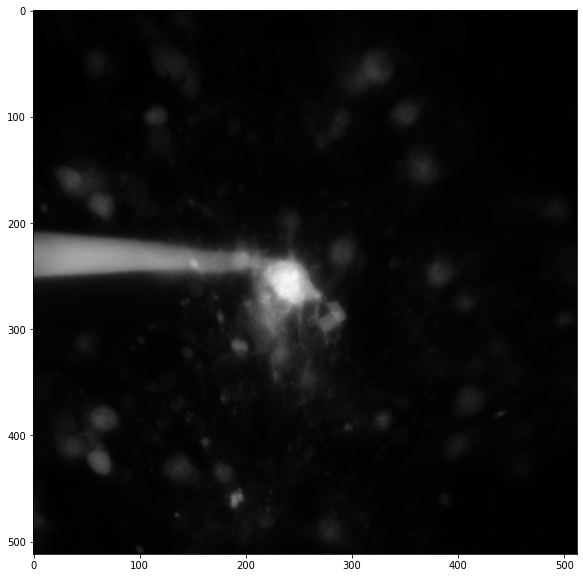

In [10]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(stack, ndisplay=3)
    else:
        imgplot = plt.imshow(np.sum(stack, axis=0))
        plt.show()

# Удаление пипетки

In [11]:
import pipette_segmentation as ps

In [12]:
image = stack

In [13]:
simple_mask = ps.make_simple_mask(image)
sato_mask = ps.make_sato_mask(image)
masks3 = ps.combine_masks(image, simple_mask, sato_mask)

vx = masks3.sum(axis=(1,2))
vx_sato = ps.st_roll(sato_mask).sum(axis=(1,2))

try:
    kink = ps.find_kink(vx)
except :
    #print(E)
    kink = len(vx)

masks3a = masks3.copy()
masks3a[kink:]=0
masks3a = ucats.masks.largest_region(masks3a)

  0%|          | 0/5 [00:00<?, ?it/s]

2022-11-16 16:20:30.401838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-11-16 16:20:30.401862: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 16:20:30.401886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (almighty): /proc/driver/nvidia/version does not exist
2022-11-16 16:20:30.412056: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

thresholds 0.12108882271466986 0.11267263972464678 0.22534527944929356
229


In [14]:
use_kink = True

In [15]:
masks3_final = masks3a if use_kink else masks3
masks3_final = np.moveaxis(masks3_final,0,2)

show_stack = (image*(~(ndi.binary_dilation(masks3_final,iterations=3)))).astype(np.float64)

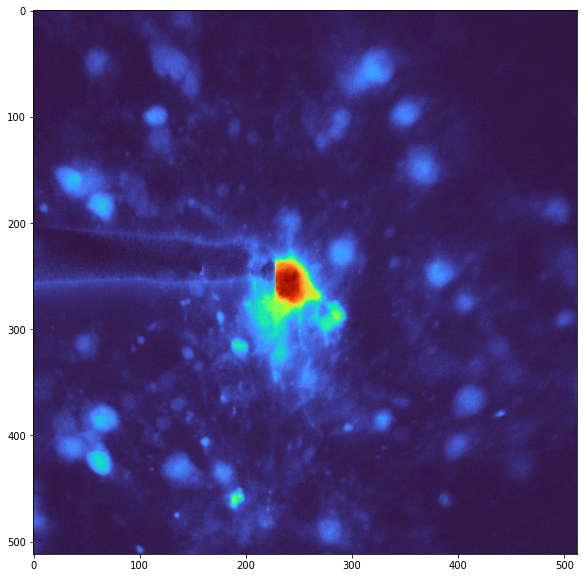

In [16]:
if VERBOSE:
    if USE_NAPARI:
        napari.view_image(show_stack, ndisplay=3)
    else:
        imgplot = plt.imshow(np.sum(show_stack, axis=0), cmap='turbo')
        plt.show()

# Предобработка изображения

## Фильтрация изображения

In [17]:
def largest_region(mask):
    labels, nlab = ndi.label(mask)
    if nlab > 0:
        objs = ndi.find_objects(labels)
        sizes = [np.sum(labels[o]==k+1) for k,o in enumerate(objs)]
        k = np.argmax(sizes)
        return labels==k+1
    else:
        return mask

In [18]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    #img_filt = np.where(image > threshold, image, 0)
    pre_mask = ndi.binary_closing(image >= threshold)
    pre_mask = remove_small_objects(pre_mask, 5, connectivity=3)
    binary_clean = largest_region(pre_mask)
    return np.where(binary_clean, image, 0)

In [19]:
img = show_stack

In [20]:
clean_img = filter_image(img, threshold_li)

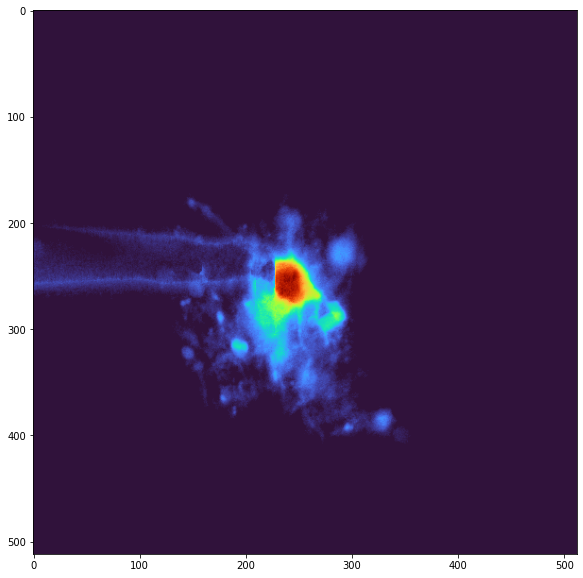

In [21]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(clean_img, opacity=0.5) 
#         w.add_image(clean_img, blending='additive')
    else:
        show_image = np.sum(clean_img, axis=0)
        imgplot = plt.imshow(show_image, cmap='turbo')
        plt.show()

## Очистка изображения

In [223]:
sigma = 6

In [22]:
def get_blobs(image, sigma):
    frangi, blobness = astro.morpho.frangi(image, sigma, beta=0.5, return_blobness=True)
    blobness2 = astro.enh.percentile_rescale(ndi.gaussian_filter(blobness, sigma), 0.1, 99.99)**2
    frangi_weights = astro.enh.percentile_rescale(frangi, 0.1, 99.9)
    mx = ucats.masks.threshold_object_size((frangi_weights > 0.5)*(blobness2 < 0.1), 27)
    saved_blobs = ucats.masks.select_overlapping(blobness2 > 0.1, ndi.binary_dilation(mx))
    return saved_blobs

In [23]:
sigmas_clear = np.linspace(4, 10, 13)

In [24]:
sigmas_clear

array([ 4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
        9.5, 10. ])

In [25]:
w = napari.view_image(clean_img, ndisplay=3, visible=True, colormap='magenta')

for sigma in tqdm(sigmas_clear):
    blobs = get_blobs(clean_img, (sigma/2, sigma, sigma))
    w.add_image(blobs, colormap='cyan',blending='additive',visible=True)    


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


  0%|          | 0/13 [00:00<?, ?it/s]

# Анализ

In [ ]:
obj = ao.AstrObject(clean_img)
print('Center')
obj.center_detection()
obj.center

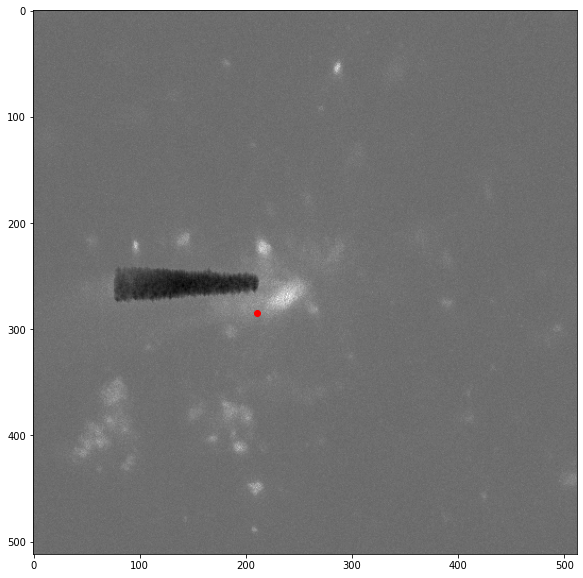

In [46]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_points(obj.center)
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        plt.scatter(*obj.center[:0:-1], c='r')
        plt.show()

In [ ]:
print('Soma Mask')
%time obj.soma_segmentation(return_shell=True)

Soma Mask
Mask Expanding


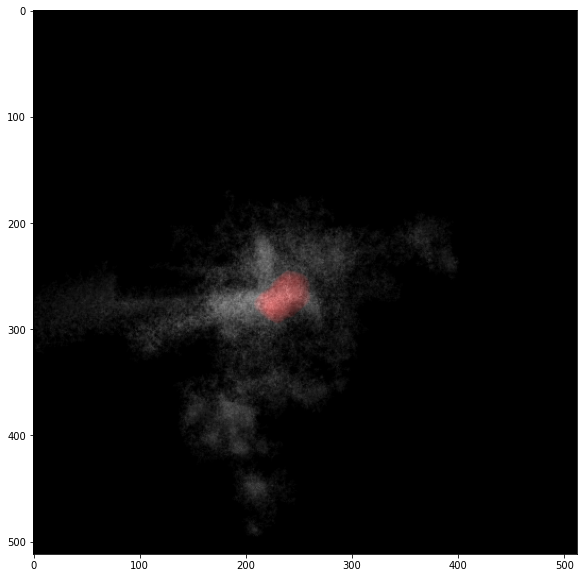

In [26]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_image(obj.soma_mask, blending='additive', colormap='red')
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        plt.imshow(np.sum(obj.soma_mask, axis=0), cmap=cmap1, alpha=0.4)
        plt.show()

In [27]:
print('Branch Segmentation')
%time obj.branch_segmentation((1,), sigmas=sigmas)

Branch Segmentation
Vectors...


Calculating:   0%|          | 0/16 [00:00<?, ?it/s]

Masks and sigmas cleaning...
Merging...
CPU times: user 7min 12s, sys: 50.8 s, total: 8min 3s
Wall time: 2min 33s


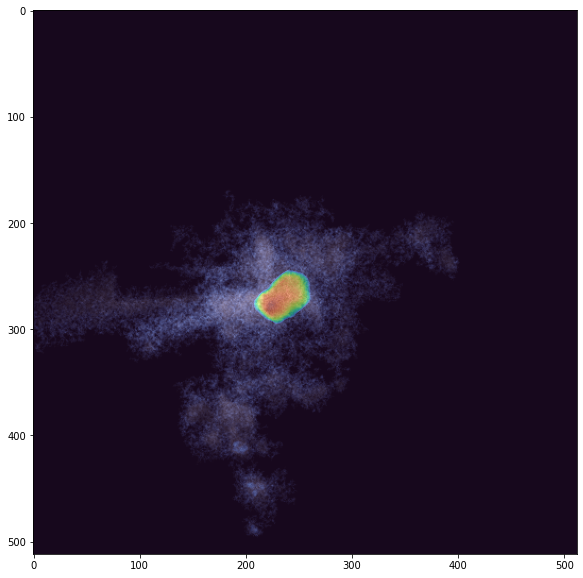

In [28]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_image(obj.sigma_mask, blending='additive', colormap='turbo')
        for sigma in obj.sigmas:
            w.add_image(obj.masks_exclusive[sigma], blending='additive', name='sigma {:.2f}'.format(sigma))
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        mask_image = obj.sigma_mask.copy()
        mask_image[obj.soma_mask] = 50
        
        plt.imshow(np.sum(mask_image, axis=0), cmap='turbo', alpha=0.5)
        plt.show()

In [29]:
print('Full Graph')
%time obj.full_graph_construction(alpha, beta, preventing_jumps=False)

Full Graph


Edge calculation:   0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 54.5 s, sys: 5.91 s, total: 1min
Wall time: 1min


In [30]:
def save_points(viewer, path=None):
    "Convert layers of a napari Viewer to a pickleable format and save to a file if path is given"
    layer_data = np.array([tuple(map(int, p)) for p in w.layers[1].data])
    if path is not None:
        #_ = v.screenshot(path.stem + '-snapshot.png')
        np.save(path, arr=layer_data)
    return layer_data

def load_my_rois(path, viewer=None):
    "load pickled layers data and add to a napari Viewer if given"
    if isinstance(path, (Path, str)):
        print('loading from file')
        layer_data = pickle.load(open(path, 'rb'))
    else:
        layer_data = path
    layers = [napari.layers.Layer.create(ld[0] if np.size(ld[0]) else None, 
                                         ld[1], ld[2]) for ld in layer_data]
    if viewer is not None:
        for ll in layers:
            viewer.add_layer(ll)
    return layers

def initiate_point_picker(image, soma_shell=None):
    w = napari.Viewer()
    w.add_image(image, blending='additive', name='cell', opacity=0.75, colormap='gist_earth')
    if soma_shell is not None:
        w.add_image(soma_shell, blending='additive', name='shell', colormap='red')
    tips_layer = w.add_points(edge_color='red', face_color='red', symbol='+', size=1, name='tips', ndim=3)
    sources_layer = w.add_points(edge_color='green', face_color='green', symbol='+', size=1, name='sources', ndim=3)
    return w

In [31]:
point_picker = initiate_point_picker(obj.image, obj.soma_shell_mask)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [32]:
if LOAD:
    points = np.load(numpy_name)
    tips = [tuple(map(int, p)) for p in points['tips']]
    sources = [tuple(map(int, p)) for p in points['sources']]

In [33]:
point_picker.add_image(obj.sigma_mask)

<Image layer 'Image' at 0x7f663a4344f0>

In [41]:
tips = [tuple(map(int, p)) for p in point_picker.layers[2].data]
sources = [tuple(map(int, p)) for p in point_picker.layers[3].data]

In [42]:
print('Targets Graph')
%time obj.tips_graph_creation(tips=tips, sources=sources)

Targets Graph


Pathing:   0%|          | 0/6 [00:00<?, ?it/s]

Composing...
Setting attributes...
CPU times: user 3.91 s, sys: 3.44 ms, total: 3.91 s
Wall time: 3.92 s


In [43]:
obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=point_picker)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 292.3821614643235, 242.2732923623041), zoom=13.079976068431755, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(49.0, 351.9388364087564, 180.49948564925333), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 80.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(49, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'cell' at 0x7f662aa71ff0>, <Image layer 'shell' at 0x7f661e1c70d0>, <Points layer 'tips' at 0x7f6627834940>, <Points layer 'sources' at 0x7f66277cbaf0>, <Image layer 'Image' at 0x7f663a4344f0>, <Image layer 'Image [1]' at 0x7f663a3d7970>, <Image layer 'Image [2]' at 0x7f662abaea70>, <Image layer 'Image [3]' at 0x7f66192d17b0>], scale_bar=ScaleBar(visible=False, c

In [158]:
_ = -1

In [346]:
point_picker.add_image(obj.sigma_mask)

<Image layer 'Image' at 0x7f657133faf0>

In [ ]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, ndisplay=3, opacity=0.5)
        obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)
    else:
        test_image = np.zeros(img.shape)
        points = np.array(list(obj.graph.nodes))
        test_image[points[:,0], points[:,1], points[:,2]] = 1
        
        sum_img = np.sum(test_image, axis=0)
        sum_img[sum_img.astype(bool)] = 1
        
        show_image = np.sum(obj.image, axis=0)
        plt.imshow(show_image, cmap='turbo')
        plt.imshow(sum_img, alpha=0.5)
#         plt.savefig(filename[:-3])

# Сохранение

In [159]:
pickle_name = os.path.join(output_dir, str(filename) + '.pickle')
numpy_name = os.path.join(output_dir, str(filename) + '.npz')

In [160]:
if OUT:
    %time pickle.dump(obj, open(pickle_name, 'wb'))
    np.savez(numpy_name, tips=tips, sources=sources)

CPU times: user 2min 10s, sys: 15.8 s, total: 2min 26s
Wall time: 2min 40s


# Просмтор результатов

In [183]:
data_dir = '/home/levtg/astro-morpho/data/human_glauk/output/'

filename = 'Т9.tif.pickle'

In [184]:
datapath = Path(data_dir).joinpath(filename)
# datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/levtg/astro-morpho/data/human_glauk/output/Т9.tif.pickle')

In [185]:
loaded = pickle.load(open(datapath, 'rb'))
# loaded = obj

Граф

In [186]:
w = napari.view_image(loaded.image, ndisplay=3, opacity=0.5)
loaded.graph.view_graph_as_colored_image(loaded.image.shape, viewer=w)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(39.5, 255.5, 255.5), zoom=3.0244140625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 80.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(40, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f391998f430>, <Image layer 'Image [1]' at 0x7f39fc27c910>, <Image layer 'Image [2]' at 0x7f3a2c277c70>, <Image layer 'Image [3]' at 0x7f39edd3ece0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: '

In [187]:
_ = -1

Клетка

In [38]:
w = napari.view_image(loaded.image, ndisplay=3)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [63]:
sources = w.layers[1].data
# tips = w.layers[2].data

In [ ]:
def get_shell_mask(mask, do_skeletonize=False, as_points=False):
    out = ndi.binary_erosion(mask)^mask
    if do_skeletonize:
        out = skeletonize(out)
    if as_points:
        out = astro.morpho.mask2points(out)
    return out 

In [ ]:
domain_mask3d = ndi.binary_fill_holes(loaded.image > 0)
domain_shell_mask = get_shell_mask(domain_mask3d)

In [ ]:
def planewise_fill_holes(mask):
    for k,plane in enumerate(mask):
        mask[k] = ndi.binary_fill_holes(plane)
    return mask

    
domain_mask3d = planewise_fill_holes(domain_mask3d)

domain_mask3d = np.moveaxis(domain_mask3d, 1, 0)   
domain_mask3d = planewise_fill_holes(domain_mask3d)
domain_mask3d = np.moveaxis(domain_mask3d, 0, 1)


domain_mask3d = np.moveaxis(domain_mask3d, 2, 0)
domain_mask3d = planewise_fill_holes(domain_mask3d)
domain_mask3d = np.moveaxis(domain_mask3d, 0, 2)

In [ ]:
domain_outer_shell_mask = get_shell_mask(domain_mask3d) & domain_shell_mask

In [ ]:
w.add_image(domain_shell_mask, colormap='green', blending='additive')
w.add_image(domain_outer_shell_mask, colormap='red', blending='additive')

Маски

In [71]:
i = -1

In [72]:
w = napari.view_image(loaded.image[:i], ndisplay=3, opacity=0.5)
w.add_image(loaded.sigma_mask[:i], blending='additive', colormap='turbo', visible=False)
for sigma in loaded.sigmas:
    w.add_image(loaded.masks[sigma][:i], blending='additive', name='sigma {:.2f}'.format(sigma), visible=False)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [46]:
points = [tuple(map(int, p)) for p in w.layers[-1].data]
points

[(46, 317, 193), (46, 290, 176)]

In [139]:
points[0] = (45, 320, 193)

In [123]:
from skimage.morphology import flood, flood_fill, dilation, ball

In [140]:
image = loaded.image.copy()

In [116]:
smooth_stack = ndi.gaussian_filter(loaded.image, 2)
w.add_image(smooth_stack)

<Image layer 'smooth_stack' at 0x7f38e9ae0910>

In [141]:
tolerance = (smooth_stack.max() - smooth_stack[loaded.image>0].min())/5
print(tolerance)
for point in points:
    blob_mask = flood(smooth_stack, point, tolerance=tolerance)
    blob_mask = dilation(blob_mask, ball(4))
    arr = flood_fill(blob_mask, (0,0,0), True)
    blob_mask += ~arr
    image[blob_mask] = 0
    w.add_image(blob_mask, blending='additive')

13065.225040463585


In [142]:
w.add_image(image)

<Image layer 'image [2]' at 0x7f390ff03250>

In [143]:
_ = -1

Векторное поле

In [519]:
mask_sum = np.zeros(loaded.image.shape, bool)
emasks = {}
for k in range(len(loaded.sigmas)-1,-1,-1):
    sigma = loaded.sigmas[k]
    mask = loaded.masks[sigma]
    if k < len(loaded.sigmas)-1:
        mask = mask & (mask ^ mask_sum)
    mask_sum += mask.astype(bool)
    emasks[sigma] = mask

KeyboardInterrupt: 

In [446]:
w = napari.view_image(loaded.image, opacity=0.5, ndisplay=3)
#     colors = ['red', 'green', 'magenta', 'cyan', 'blue']

for sigma in list(loaded.masks.keys())[:-1]:
    vectors = loaded.vectors[emasks[sigma]]
#     print('Vectors shape:', vectors.shape)
    nd, nr, nc = loaded.image.shape
    #indexgrid = np.meshgrid(np.arange(nd), np.arange(nr), np.arange(nc), indexing='ij')
    indexgrid = np.mgrid[:nd, :nr, :nc]
#     print('Indexgrid shape:', indexgrid[0].shape)

    z, y, x = [np.ravel(a[emasks[sigma]]) for a in indexgrid]
    z1, y1, x1 = vectors[:,0], vectors[:,1], vectors[:,2]

#     print('XYZ shapes:', x.shape, y.shape, z.shape)
#     print('X1Y1Z1 shapes:', x1.shape, y1.shape, z1.shape)

    vecs = np.zeros((vectors.shape[0], 2, 3))

    vecs[..., 0, 0] = z
    vecs[..., 0, 1] = y
    vecs[..., 0, 2] = x
    #
    vecs[..., 1, 0] = z1
    vecs[..., 1, 1] = y1
    vecs[..., 1, 2] = x1
    #
    properties = {'length': loaded.sato[emasks[sigma]]}
    w.add_vectors(vecs, edge_width=0.1,  
                  properties=properties,
                  edge_color='length', 
                  edge_colormap='turbo', 
                  name=f'σ={sigma:.2f}', visible=False)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
